<a id='top'> </a>

In [1]:
%load_ext watermark
%watermark -a 'Author: James Bourbeau' -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

Author: James Bourbeau 
last updated: 2017-03-14 

CPython 2.7.10
IPython 5.3.0

numpy 1.12.0
matplotlib 2.0.0
scipy 0.15.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Cosmic-ray composition spectrum analysis
### Table of contents
1. [Define analysis free parameters](#Define-analysis-free-parameters)
1. [Data preprocessing](#Data-preprocessing)
2. [Fitting random forest](#Fit-random-forest-and-run-10-fold-CV-validation)
3. [Fraction correctly identified](#Fraction-correctly-identified)
4. [Spectrum](#Spectrum)
5. [Unfolding](#Unfolding)

In [2]:
from __future__ import division, print_function
from collections import defaultdict
import itertools
import numpy as np
from scipy import interp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn.apionly as sns
import matplotlib as mpl
import pyprind

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold, StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import composition as comp
import composition.analysis.plotting as plotting
    
# color_dict allows for a consistent color-coding for each composition
color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define analysis free parameters
[ [back to top](#top) ]

Whether or not to train on 'light' and 'heavy' composition classes, or the individual compositions

In [3]:
comp_class = True
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

Get composition classifier pipeline

In [4]:
pipeline_str = 'GBDT'
pipeline = comp.get_pipeline(pipeline_str)

Define energy binning for this analysis

In [5]:
energybins = comp.analysis.get_energybins()

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature transformation

In [6]:
sim_train, sim_test = comp.preprocess_sim(comp_class=comp_class, return_energy=True)

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
              InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	$\log_{10}$(dE/dX)
	$R_{\mathrm{max}}$
	
Number training events = 208926
Number testing events = 89540


In [7]:
# Compute the correlation matrix
df_sim = comp.load_dataframe(datatype='sim', config='IC79')
feature_list, feature_labels = comp.analysis.get_training_features()

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
              InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75




/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


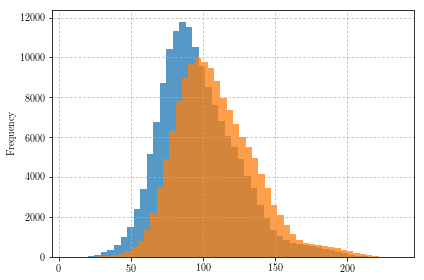

In [8]:
fig, ax = plt.subplots()
df_sim[df_sim.MC_comp_class == 'light'].avg_inice_radius.plot(kind='hist', bins=50, ax=ax, alpha=0.75)
df_sim[df_sim.MC_comp_class == 'heavy'].avg_inice_radius.plot(kind='hist', bins=50, ax=ax, alpha=0.75)
ax.grid()
plt.show()

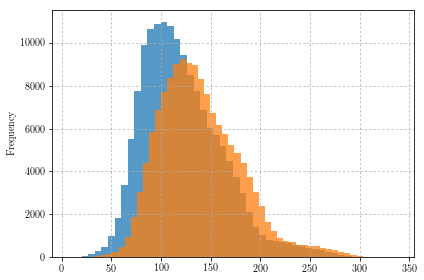

In [9]:
fig, ax = plt.subplots()
df_sim[df_sim.MC_comp_class == 'light'].invcharge_inice_radius.plot(kind='hist', bins=50, ax=ax, alpha=0.75)
df_sim[df_sim.MC_comp_class == 'heavy'].invcharge_inice_radius.plot(kind='hist', bins=50, ax=ax, alpha=0.75)
ax.grid()
plt.show()

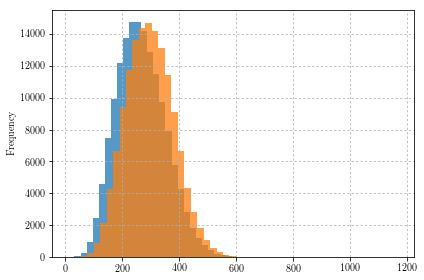

In [10]:
fig, ax = plt.subplots()
df_sim[df_sim.MC_comp_class == 'light'].max_inice_radius.plot(kind='hist', bins=50, ax=ax, alpha=0.75)
df_sim[df_sim.MC_comp_class == 'heavy'].max_inice_radius.plot(kind='hist', bins=50, ax=ax, alpha=0.75)
ax.grid()
plt.show()

/home/jbourbeau/.local/lib/python2.7/site-packages/seaborn/matrix.py:143: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:
/home/jbourbeau/.local/lib/python2.7/site-packages/seaborn/matrix.py:151: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if yticklabels == []:


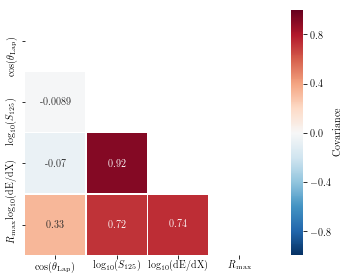

In [11]:
corr = df_sim[feature_list].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
sns.heatmap(corr, mask=mask, cmap='RdBu_r', center=0,
            square=True, xticklabels=feature_labels, yticklabels=feature_labels,
            linewidths=.5, cbar_kws={'label': 'Covariance'}, annot=True, ax=ax)
# outfile = args.outdir + '/feature_covariance.png'
# plt.savefig(outfile)
plt.show()

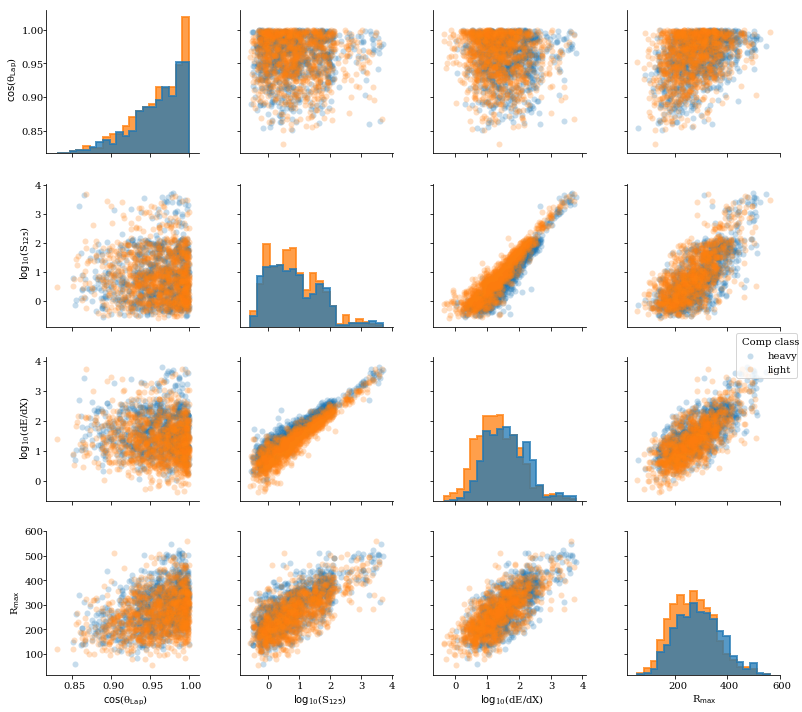

In [12]:
label_replacement = {feature: labels for feature, labels in zip(feature_list, feature_labels)}
with plt.rc_context({'text.usetex': False}):
    g = sns.pairplot(df_sim.sample(frac=1)[:2000], vars=feature_list, hue='MC_comp_class',
                     plot_kws={'alpha': 0.25, 'linewidth': 0},
                     diag_kws={'histtype': 'step', 'linewidth': 2, 'fill': True, 'alpha': 0.75, 'bins': 20})
    # Replace axes labels
    for i in range(len(feature_list)):
        for j in range(len(feature_list)):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel in label_replacement.keys():
                g.axes[i][j].set_xlabel(label_replacement[xlabel])
            if ylabel in label_replacement.keys():
                g.axes[i][j].set_ylabel(label_replacement[ylabel])
    
    g.fig.get_children()[-1].set_title('Comp class')            
#     g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

In [16]:
data = comp.preprocess_data(comp_class=comp_class, return_energy=True)

data quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:    1.0    1.0
              InIceQualityCuts:    0.9    0.9
                 num_hits_1_60:    1.0    0.9




/home/jbourbeau/cr-composition/composition/dataframe_functions.py:137: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	$\log_{10}$(dE/dX)
	
Number testing events = 7212805


In [17]:
is_finite_mask = np.isfinite(data.X)
not_finite_mask = np.logical_not(is_finite_mask)
finite_data_mask = np.logical_not(np.any(not_finite_mask, axis=1))
data = data[finite_data_mask]

Run classifier over training and testing sets to get an idea of the degree of overfitting

In [13]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)
weights = sim_train.energy**-1.7
pipeline.fit(sim_train.X, sim_train.y)
# pipeline.fit(sim_train.X, sim_train.y, classifier__sample_weight=weights)
train_pred = pipeline.predict(sim_train.X)
train_acc = accuracy_score(sim_train.y, train_pred)
print('Training accuracy = {:.2%}'.format(train_acc))
test_pred = pipeline.predict(sim_test.X)
test_acc = accuracy_score(sim_test.y, test_pred)
print('Testing accuracy = {:.2%}'.format(test_acc))
print('=' * 30)

GradientBoostingClassifier
Training accuracy = 75.64%
Testing accuracy = 75.08%


1) 0.423824504852
2) 0.33713576144
3) 0.153127065688
4) 0.0859126680202


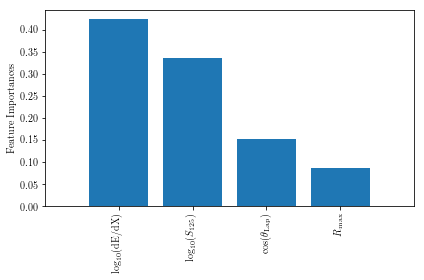

In [14]:
num_features = len(feature_list)
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()
for f in range(num_features):
    print('{}) {}'.format(f + 1, importances[indices[f]]))

plt.ylabel('Feature Importances')
plt.bar(range(num_features),
        importances[indices],
        align='center')

plt.xticks(range(num_features),
           feature_labels[indices], rotation=90)
plt.xlim([-1, len(feature_list)])
plt.show()

## Fraction correctly identified
[ [back to top](#top) ]

Calculate classifier performance via 10-fold CV

In [15]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
frac_correct_folds = defaultdict(list)
bar = pyprind.ProgBar(10, monitor=True, title='10-fold CV', stream=1)
for train_index, test_index in skf.split(sim_train.X, sim_train.y):
    reco_frac, reco_frac_err = comp.analysis.get_frac_correct(sim_train[train_index], sim_train[test_index],
                                                pipeline, comp_list)
        
    for composition in comp_list+['total']:
        frac_correct_folds[composition].append(reco_frac[composition])
    
    bar.update(force_flush=True)
    
frac_correct_gen_err = {key: np.std(frac_correct_folds[key], axis=0) for key in frac_correct_folds}
print(bar)

10-fold CV
0%      100%
[##########] | ETA: 00:07:06 | ETA: 00:06:53 | ETA: 00:06:13 | ETA: 00:05:12 | ETA: 00:04:12 | ETA: 00:03:32 | ETA: 00:02:39 | ETA: 00:01:45 | ETA: 00:00:54 | ETA: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:09:24
Title: 10-fold CV
  Started: 03/14/2017 22:43:47
  Finished: 03/14/2017 22:53:12
  Total time elapsed: 00:09:24
  CPU %: 100.30
  Memory %: 0.93


#### Plot fraction of events correctlty classified vs energy
This is done via 10-fold cross-validation. This will give an idea as to how much variation there is in the classifier due to different trainig and testing samples. 

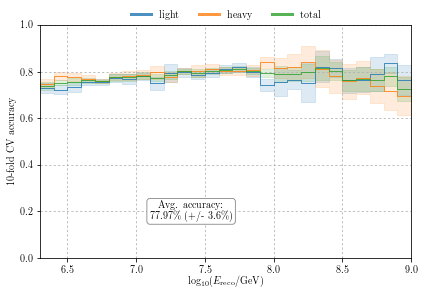

In [17]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    performance_mean = np.mean(frac_correct_folds[composition], axis=0)
    performance_std = np.std(frac_correct_folds[composition], axis=0)
#     err = np.sqrt(frac_correct_gen_err[composition]**2 + reco_frac_stat_err[composition]**2)
    plotting.plot_steps(energybins.log_energy_midpoints, performance_mean, performance_std, ax,
                        color_dict[composition], composition)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('10-fold CV accuracy')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.grid()
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

cv_str = 'Avg. accuracy:\n{:0.2f}\% (+/- {:0.1f}\%)'.format(np.mean(frac_correct_folds['total'])*100,
                                                      np.std(frac_correct_folds['total'])*100)
ax.text(7.4, 0.2, cv_str,
        ha="center", va="center", size=10,
        bbox=dict(boxstyle='round', fc="white", ec="gray", lw=0.8))
plt.savefig('/home/jbourbeau/public_html/figures/frac-correct-{}.png'.format(pipeline_str))
plt.show()

Determine the mean and standard deviation of the fraction correctly classified for each energy bin

In [18]:
avg_frac_correct_data = {'values': np.mean(frac_correct_folds['total'], axis=0), 'errors': np.std(frac_correct_folds['total'], axis=0)}
avg_frac_correct, avg_frac_correct_err = comp.analysis.averaging_error(**avg_frac_correct_data)

In [19]:
reco_frac, reco_frac_stat_err = comp.analysis.get_frac_correct(sim_train, sim_test, pipeline, comp_list)

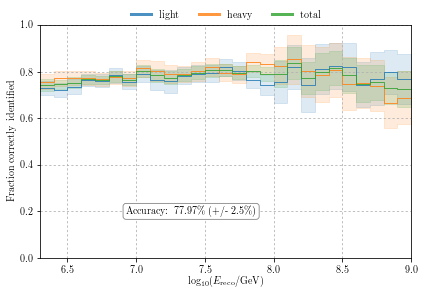

In [20]:
# Plot fraction of events correctlt classified vs energy
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    err = np.sqrt(frac_correct_gen_err[composition]**2 + reco_frac_stat_err[composition]**2)
    plotting.plot_steps(energybins.log_energy_midpoints, reco_frac[composition], err, ax,
                        color_dict[composition], composition)
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Fraction correctly identified')
ax.set_ylim([0.0, 1.0])
ax.set_xlim([energybins.log_energy_min, energybins.log_energy_max])
ax.grid()
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

cv_str = 'Accuracy: {:0.2f}\% (+/- {:0.1f}\%)'.format(avg_frac_correct*100, avg_frac_correct_err*100)
ax.text(7.4, 0.2, cv_str,
        ha="center", va="center", size=10,
        bbox=dict(boxstyle='round', fc="white", ec="gray", lw=0.8))
plt.savefig('/home/jbourbeau/public_html/figures/frac-correct-{}.png'.format(pipeline_str))
plt.show()

Plot the two-class decision scores

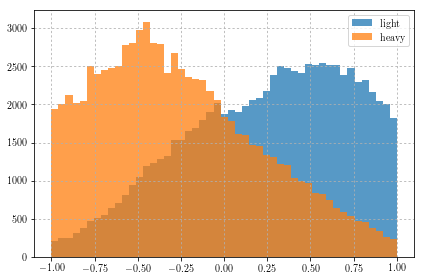

In [21]:
classifier_score = pipeline.decision_function(sim_train.X)
light_mask = sim_train.le.inverse_transform(sim_train.y) == 'light'
heavy_mask = sim_train.le.inverse_transform(sim_train.y) == 'heavy'
fig, ax = plt.subplots()
score_bins = np.linspace(-1, 1, 50)
ax.hist(classifier_score[light_mask], bins=score_bins, label='light', alpha=0.75)
ax.hist(classifier_score[heavy_mask], bins=score_bins, label='heavy', alpha=0.75)
ax.grid()
ax.legend()
plt.show()

In [30]:
import multiprocessing as mp

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
frac_correct_folds = defaultdict(list)

# Define output queues
frac_correct_queue = mp.Queue()
frac_correct_err_queue = mp.Queue()

def get_frac_correct_mp(train, test, pipeline, comp_list, frac_queue, err_queue):
    
    assert isinstance(train, comp.analysis.DataSet), 'train dataset must be a DataSet'
    assert isinstance(test, comp.analysis.DataSet), 'test dataset must be a DataSet'
    assert train.y is not None, 'train must have true y values'
    assert test.y is not None, 'test must have true y values'
    
    pipeline.fit(train.X, train.y)
    test_predictions = pipeline.predict(test.X)
    correctly_identified_mask = (test_predictions == test.y)

    # Construct MC composition masks
    MC_comp_mask = {}
    for composition in comp_list:
        MC_comp_mask[composition] = (test.le.inverse_transform(test.y) == composition)
    MC_comp_mask['total'] = np.array([True]*len(test))
    
    reco_frac, reco_frac_err = {}, {}
    for composition in comp_list+['total']:
        comp_mask = MC_comp_mask[composition]
        # Get number of MC comp in each reco energy bin
        num_MC_energy = np.histogram(test.log_energy[comp_mask],
                                     bins=energybins.log_energy_bins)[0]
        num_MC_energy_err = np.sqrt(num_MC_energy)

        # Get number of correctly identified comp in each reco energy bin
        num_reco_energy = np.histogram(test.log_energy[comp_mask & correctly_identified_mask],
                                       bins=energybins.log_energy_bins)[0]
        num_reco_energy_err = np.sqrt(num_reco_energy)

        # Calculate correctly identified fractions as a function of MC energy
        reco_frac[composition], reco_frac_err[composition] = comp.ratio_error(
            num_reco_energy, num_reco_energy_err,
            num_MC_energy, num_MC_energy_err)
    
    frac_correct_queue.put(reco_frac)
    frac_correct_err_queue.put(reco_frac_err)

# Setup a list of processes that we want to run
print('setting up processes...')
processes = []
for train_index, test_index in skf.split(sim_train.X, sim_train.y):
    process = mp.Process(target=get_frac_correct_mp, args=(sim_train[train_index], sim_train[test_index],
                                                           pipeline, comp_list, frac_correct_queue,
                                                           frac_correct_err_queue))
    processes.append(process)
    
# Run processes
for fold_idx, p in enumerate(processes):
    print('Starting fold {}'.format(fold_idx))
    p.start()

# Exit the completed processes
for fold_idx, p in enumerate(processes):
    print('Finishing fold {}'.format(fold_idx))
    p.join()

# Get process results from the output queue
frac_correct = [frac_correct_queue.get() for p in processes]
frac_correct_err = [frac_correct_err_queue.get() for p in processes]

print('frac_correct = {}'.format(frac_correct))
print('frac_correct_err = {}'.format(frac_correct_err))

setting up processes...
Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3
Processing fold 4
Processing fold 5
Processing fold 6
Processing fold 7
Processing fold 8
Processing fold 9
Finishing fold 0
Finishing fold 1
Finishing fold 2
Finishing fold 3
Finishing fold 4
Finishing fold 5
Finishing fold 6
Finishing fold 7
Finishing fold 8
Finishing fold 9
frac_correct = [{'heavy': array([ 0.73319328,  0.78125   ,  0.79411765,  0.78177966,  0.76470588,
        0.79277567,  0.78475336,  0.74147727,  0.79807692,  0.76025237,
        0.78424658,  0.76716418,  0.82154882,  0.78917379,  0.80617978,
        0.83591331,  0.80981595,  0.8452381 ,  0.82692308,  0.86842105,
        0.84090909,  0.83333333,  0.73809524,  0.86666667,  0.76923077,
        0.56818182,  0.68965517]), 'light': array([ 0.69736842,  0.70340681,  0.75494071,  0.74701195,  0.73632812,
        0.78764479,  0.7805383 ,  0.78323699,  0.778125  ,  0.8489426 ,
        0.80592105,  0.8125    ,  0.78153846,  0.823

## Spectrum
[ [back to top](#top) ]

In [18]:
def get_num_comp_reco(train, test, pipeline, comp_list):
    
    assert isinstance(train, comp.analysis.DataSet), 'train dataset must be a DataSet'
    assert isinstance(test, comp.analysis.DataSet), 'test dataset must be a DataSet'
    assert train.y is not None, 'train must have true y values'
    
    pipeline.fit(train.X, train.y)
    test_predictions = pipeline.predict(test.X)

    # Get number of correctly identified comp in each reco energy bin
    num_reco_energy, num_reco_energy_err = {}, {}
    for composition in comp_list:
#         print('composition = {}'.format(composition))
        comp_mask = train.le.inverse_transform(test_predictions) == composition
#         print('sum(comp_mask) = {}'.format(np.sum(comp_mask)))
        print(test.log_energy[comp_mask])
        num_reco_energy[composition] = np.histogram(test.log_energy[comp_mask],
            bins=energybins.log_energy_bins)[0]
        num_reco_energy_err[composition] = np.sqrt(num_reco_energy[composition])

    num_reco_energy['total'] = np.histogram(test.log_energy, bins=energybins.log_energy_bins)[0]
    num_reco_energy_err['total'] = np.sqrt(num_reco_energy['total'])
    
    return num_reco_energy, num_reco_energy_err

In [19]:
df_sim = comp.load_dataframe(datatype='sim', config='IC79')

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
              InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75




In [20]:
df_sim[['log_dEdX', 'num_millipede_particles']].corr()

,log_dEdX,num_millipede_particles
log_dEdX,1.000000,-0.048842
num_millipede_particles,-0.048842,1.000000


In [21]:
max_zenith_rad = df_sim['lap_zenith'].max()

In [22]:
# Get number of events per energy bin
num_reco_energy, num_reco_energy_err = get_num_comp_reco(sim_train, data, pipeline, comp_list)
import pprint
pprint.pprint(num_reco_energy)
pprint.pprint(num_reco_energy_err)
# Solid angle
solid_angle = 2*np.pi*(1-np.cos(max_zenith_rad))

[ 6.084369    6.02108021  6.19372399 ...,  6.34287938  5.58828732
  6.30276075]
[ 6.09036488  6.04362939  6.22640939 ...,  6.23452475  6.24879068
  5.93383339]
{'heavy': array([333373, 247362, 171104, 111037,  71072,  46386,  31339,  20151,
        12939,   8385,   5905,   3940,   2625,   1823,   1105,    760,
          457,    351,    181,     96,     59,     34,     21,     17,
            6,      8,      4]),
 'light': array([359917, 246830, 166187, 111450,  71146,  43352,  24185,  13594,
         7618,   4381,   2489,   1435,    915,    486,    300,    168,
           81,     45,     26,     11,      5,      6,      3,      3,
            1,      2,      1]),
 'total': array([693290, 494192, 337291, 222487, 142218,  89738,  55524,  33745,
        20557,  12766,   8394,   5375,   3540,   2309,   1405,    928,
          538,    396,    207,    107,     64,     40,     24,     20,
            7,     10,      5])}
{'heavy': array([ 577.38462051,  497.355004  ,  413.64719267,  333.22214

In [23]:
print(num_reco_energy['light'].sum())
print(num_reco_energy['heavy'].sum())
frac_light = num_reco_energy['light'].sum()/num_reco_energy['total'].sum()
print(frac_light)

1054637
1070540
0.496258429298


In [24]:
# Live-time information
goodrunlist = pd.read_table('/data/ana/CosmicRay/IceTop_GRL/IC79_2010_GoodRunInfo_4IceTop.txt', skiprows=[0, 3])
goodrunlist.head()

,RunNum,Good_i3,Good_it,Good_it_L2,LiveTime(s),ActiveStrings,ActiveDoms,ActiveInIceDoms,OutDir,Comment(s)
0,115978,1,1,0,26856,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0531,NaN
1,115982,1,1,1,28548,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0531,NaN
2,115984,1,1,1,6984,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0601,NaN
3,115985,1,1,1,10476,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0601,NaN
4,115986,1,1,1,28872,-,-,-,/data/exp/IceCube/2010/filtered/level2a/0601,NaN


In [25]:
livetimes = goodrunlist['LiveTime(s)']
livetime = np.sum(livetimes[goodrunlist['Good_it_L2'] == 1])
print('livetime (seconds) = {}'.format(livetime))
print('livetime (days) = {}'.format(livetime/(24*60*60)))

livetime (seconds) = 27114012
livetime (days) = 313.819583333


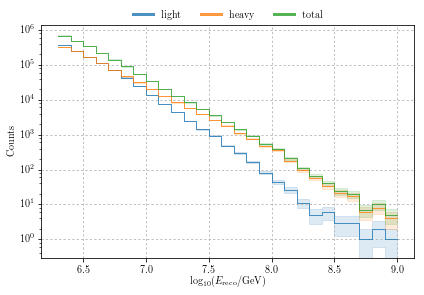

In [26]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = num_reco_energy[composition]
    y_err = num_reco_energy_err[composition]

    plotting.plot_steps(energybins.log_energy_midpoints, y, y_err,
                        ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Counts')
# ax.set_xlim([6.3, 8.0])
# ax.set_ylim([10**-6, 10**-1])
ax.grid(linestyle=':')
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.savefig('/home/jbourbeau/public_html/figures/rate.png')
plt.show()

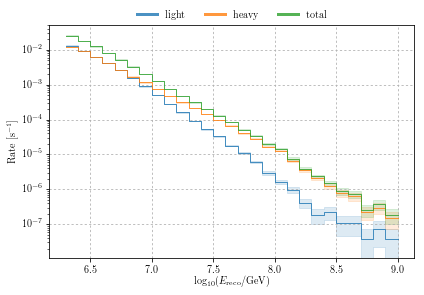

In [27]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    # Calculate dN/dE
    y = num_reco_energy[composition]
    y_err = num_reco_energy_err[composition]
    # Add time duration
#     y = y / livetime
#     y_err = y / livetime
    y, y_err = comp.analysis.ratio_error(y, y_err, livetime, 0.005*livetime)
    plotting.plot_steps(energybins.log_energy_midpoints, y, y_err,
                        ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
ax.set_ylabel('Rate [s$^{-1}$]')
# ax.set_xlim([6.3, 8.0])
# ax.set_ylim([10**-6, 10**-1])
ax.grid(linestyle=':')
leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.1),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.savefig('/home/jbourbeau/public_html/figures/rate.png')
plt.show()

In [28]:
df_sim, cut_dict_sim = comp.load_dataframe(datatype='sim', config='IC79', return_cut_dict=True)
selection_mask = np.array([True] * len(df_sim))
standard_cut_keys = ['IceTopQualityCuts', 'lap_InIce_containment',
                'num_hits_1_60',
#                 'num_hits_1_60', 'max_qfrac_1_60',
                'InIceQualityCuts']
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]

df_sim = df_sim[selection_mask]

/home/jbourbeau/cr-composition/composition/dataframe_functions.py:137: RuntimeWarning: divide by zero encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


In [23]:
def get_energy_res(df_sim, energy_bins):
    reco_log_energy = df_sim['lap_log_energy'].values 
    MC_log_energy = df_sim['MC_log_energy'].values
    energy_res = reco_log_energy - MC_log_energy
    bin_centers, bin_medians, energy_err = comp.analysis.data_functions.get_medians(reco_log_energy,
                                                                               energy_res,
                                                                               energy_bins)
    return np.abs(bin_medians)

In [37]:
def counts_to_flux(counts, counts_err, eff_area=156390.673059, livetime=1):
    # Calculate dN/dE
    y = counts/energybins.energy_bin_widths
    y_err = counts_err/energybins.energy_bin_widths
    # Add effective area
    eff_area = np.array([eff_area]*len(y))
    eff_area_error = np.array([0.01 * eff_area]*len(y_err))
    y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
    # Add solid angle
    y = y / solid_angle
    y_err = y_err / solid_angle
    # Add time duration
#     y = y / livetime
#     y_err = y / livetime
    livetime = np.array([livetime]*len(y))
    flux, flux_err = comp.analysis.ratio_error(y, y_err, livetime, 0.01*livetime)
    # Add energy scaling 
    scaled_flux = energybins.energy_midpoints**2.7 * flux
    scaled_flux_err = energybins.energy_midpoints**2.7 * flux_err

    return scaled_flux, scaled_flux_err

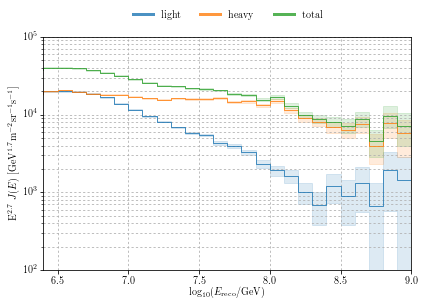

In [38]:
# Plot fraction of events vs energy
# fig, ax = plt.subplots(figsize=(8, 6))
fig = plt.figure()
ax = plt.gca()
for composition in comp_list + ['total']:
    y, y_err = counts_to_flux(num_reco_energy[composition], num_reco_energy_err[composition], livetime=livetime)
    plotting.plot_steps(energybins.log_energy_midpoints, y, y_err, ax, color_dict[composition], composition)
ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
# ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_ylabel('$\mathrm{E}^{2.7} \ J(E) \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([6.4, 9.0])
ax.set_ylim([10**2, 10**5])
ax.grid(linestyle='dotted', which="both")
    
# Add 3-year scraped flux
df_proton = pd.read_csv('3yearscraped/proton', sep='\t', header=None, names=['energy', 'flux'])
df_helium = pd.read_csv('3yearscraped/helium', sep='\t', header=None, names=['energy', 'flux'])
df_light = pd.DataFrame.from_dict({'energy': df_proton.energy, 
                                  'flux': df_proton.flux + df_helium.flux})

df_oxygen = pd.read_csv('3yearscraped/oxygen', sep='\t', header=None, names=['energy', 'flux'])
df_iron = pd.read_csv('3yearscraped/iron', sep='\t', header=None, names=['energy', 'flux'])
df_heavy = pd.DataFrame.from_dict({'energy': df_oxygen.energy, 
                                  'flux': df_oxygen.flux + df_iron.flux})

# if comp_class:
#     ax.plot(np.log10(df_light.energy), df_light.flux, label='3 yr light',
#             marker='.', ls=':')
#     ax.plot(np.log10(df_heavy.energy), df_heavy.flux, label='3 yr heavy',
#             marker='.', ls=':')
#     ax.plot(np.log10(df_heavy.energy), df_heavy.flux+df_light.flux, label='3 yr total',
#             marker='.', ls=':')
# else:
#     ax.plot(np.log10(df_proton.energy), df_proton.flux, label='3 yr proton',
#             marker='.', ls=':')
#     ax.plot(np.log10(df_helium.energy), df_helium.flux, label='3 yr helium',
#             marker='.', ls=':', color=color_dict['He'])
#     ax.plot(np.log10(df_oxygen.energy), df_oxygen.flux, label='3 yr oxygen',
#             marker='.', ls=':', color=color_dict['O'])
#     ax.plot(np.log10(df_iron.energy), df_iron.flux, label='3 yr iron',
#         marker='.', ls=':', color=color_dict['Fe'])
#     ax.plot(np.log10(df_iron.energy), df_proton.flux+df_helium.flux+df_oxygen.flux+df_iron.flux, label='3 yr total',
#     marker='.', ls=':', color='C2')


leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.15),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.savefig('/home/jbourbeau/public_html/figures/spectrum.png')
plt.show()

In [24]:
if not comp_class:
    # Add 3-year scraped flux
    df_proton = pd.read_csv('3yearscraped/proton', sep='\t', header=None, names=['energy', 'flux'])
    df_helium = pd.read_csv('3yearscraped/helium', sep='\t', header=None, names=['energy', 'flux'])
    df_oxygen = pd.read_csv('3yearscraped/oxygen', sep='\t', header=None, names=['energy', 'flux'])
    df_iron = pd.read_csv('3yearscraped/iron', sep='\t', header=None, names=['energy', 'flux'])
    # Plot fraction of events vs energy
    fig, axarr = plt.subplots(2, 2, figsize=(8, 6))
    for composition, ax in zip(comp_list + ['total'], axarr.flatten()):
        # Calculate dN/dE
        y = num_reco_energy[composition]/energybins.energy_bin_widths
        y_err = num_reco_energy_err[composition]/energybins.energy_bin_widths
        # Add effective area
        y, y_err = comp.analysis.ratio_error(y, y_err, eff_area, eff_area_error)
        # Add solid angle
        y = y / solid_angle
        y_err = y_err / solid_angle
        # Add time duration
        y = y / livetime
        y_err = y / livetime
        y = energybins.energy_midpoints**2.7 * y
        y_err = energybins.energy_midpoints**2.7 * y_err
        plotting.plot_steps(energybins.log_energy_midpoints, y, y_err, ax, color_dict[composition], composition)
        # Load 3-year flux
        df_3yr = pd.read_csv('3yearscraped/{}'.format(composition), sep='\t',
                             header=None, names=['energy', 'flux'])
        ax.plot(np.log10(df_3yr.energy), df_3yr.flux, label='3 yr {}'.format(composition),
                        marker='.', ls=':', color=color_dict[composition])
        ax.set_yscale("log", nonposy='clip')
        # ax.set_xscale("log", nonposy='clip')
        ax.set_xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
        ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
        ax.set_xlim([6.3, 8])
        ax.set_ylim([10**3, 10**5])
        ax.grid(linestyle='dotted', which="both")
        ax.legend()

    plt.savefig('/home/jbourbeau/public_html/figures/spectrum.png')
    plt.show()

## Unfolding
[ [back to top](#top) ]

In [56]:
bin_midpoints, _, counts, counts_err = comp.get1d('/home/jbourbeau/PyUnfold/unfolded_output_h3a.root', 'NC', 'Unf_ks_ACM/bin0')

In [57]:
light_counts = counts[::2]
heavy_counts = counts[1::2]
light_counts, heavy_counts

(array([  0.00000000e+00,   0.00000000e+00,   3.94173531e+05,
          2.63614250e+05,   1.71530094e+05,   1.14683633e+05,
          7.17663828e+04,   4.54102812e+04,   2.53020430e+04,
          1.44541113e+04,   8.22012500e+03,   4.64797754e+03,
          2.68499121e+03,   1.53414001e+03,   9.23193542e+02,
          5.25730347e+02,   3.50056732e+02,   2.16206818e+02,
          1.10547867e+02,   5.41976204e+01,   3.78875351e+01,
          1.34613190e+01,   6.46755743e+00,   6.38315153e+00,
          4.67412901e+00,   4.20421267e+00,   1.28977835e+00]),
 array([  0.00000000e+00,   0.00000000e+00,   2.99116469e+05,
          2.30577750e+05,   1.65760906e+05,   1.07803367e+05,
          7.04516172e+04,   4.43277188e+04,   3.02219570e+04,
          1.92908887e+04,   1.23368750e+04,   8.11802246e+03,
          5.70900879e+03,   3.84085986e+03,   2.61680640e+03,
          1.78326965e+03,   1.05494324e+03,   7.11793213e+02,
          4.27452148e+02,   3.41802368e+02,   1.69112457e+02,
      

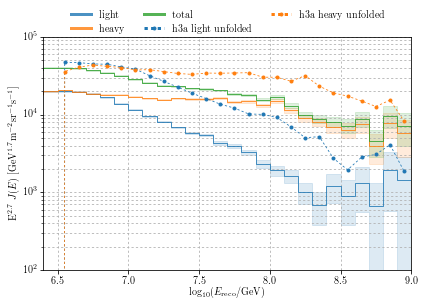

In [58]:
fig, ax = plt.subplots()
for composition in comp_list + ['total']:
    y, y_err = counts_to_flux(num_reco_energy[composition], num_reco_energy_err[composition], livetime=livetime)
    plotting.plot_steps(energybins.log_energy_midpoints, y, y_err, ax, color_dict[composition], composition)
    
h3a_light_flux, h3a_flux_err = counts_to_flux(light_counts, np.sqrt(light_counts), livetime=livetime)
h3a_heavy_flux, h3a_flux_err = counts_to_flux(heavy_counts, np.sqrt(heavy_counts), livetime=livetime)

ax.plot(energybins.log_energy_midpoints, h3a_light_flux, ls=':', label='h3a light unfolded')
ax.plot(energybins.log_energy_midpoints, h3a_heavy_flux, ls=':', label='h3a heavy unfolded')

ax.set_yscale("log", nonposy='clip')
plt.xlabel('$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$')
# ax.set_ylabel('$\mathrm{E}^{2.7} \\frac{\mathrm{dN}}{\mathrm{dE dA d\Omega dt}} \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_ylabel('$\mathrm{E}^{2.7} \ J(E) \ [\mathrm{GeV}^{1.7} \mathrm{m}^{-2} \mathrm{sr}^{-1} \mathrm{s}^{-1}]$')
ax.set_xlim([6.4, 9.0])
ax.set_ylim([10**2, 10**5])
ax.grid(linestyle='dotted', which="both")
    

leg = plt.legend(loc='upper center', frameon=False,
          bbox_to_anchor=(0.5,  # horizontal
                          1.15),# vertical 
          ncol=len(comp_list)+1, fancybox=False)
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

plt.savefig('/home/jbourbeau/public_html/figures/spectrum-unfolded.png')
plt.show()